In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
def one_hot(lst, num_class=3) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    activity = activity[activity["label"]!="retained"]
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

 <br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(75000, 8, 38)
(75000, 3)


<br></br><br></br><br></br>

# Model

In [7]:
class CNN() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def convolution(self, input_X, kernel_size, width, num_filter, activation=True) :
        conv = tf.layers.conv2d(input_X, filters=num_filter, kernel_size=[kernel_size, width], strides=1)
        
        if activation :
            norm = tf.contrib.layers.layer_norm(conv)
            relu = tf.nn.relu(norm)
        
            return relu
        return conv
        
    def build(self, batch_size, height, width, depth, is_embedding, emb_width, num_filter, is_fc, fc_num_unit, fc_activation, cost_function, output_dim) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            self.batch_size = batch_size
            self.height = height
            self.width = width
            self.depth = depth
            self.is_embedding = is_embedding
            self.emb_width = emb_width
            self.num_filter = num_filter
            self.is_fc = is_fc
            self.fc_num_unit = fc_num_unit
            self.fc_activation = fc_activation
            self.output_dim = output_dim
            
            self.X = tf.placeholder(tf.float32, [None, self.height, self.width])
            self.Y = tf.placeholder(tf.float32, [None, self.output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            #############
            
            
            ## Embedding ##
            if self.is_embedding :
                W_emb = tf.Variable(tf.random_normal([self.width, self.emb_width]))
                self.X = tf.concat(self.X, tf.matmul(self.X, W_emb), axis=2)
                
            reshaped_X = tf.reshape(self.X, [-1, self.height, self.width, self.depth])
            ###############
            
            
            ## Convolution ##
            conv1 = self.convolution(reshaped_X, 1, self.width, self.num_filter)
            conv1 = self.convolution(conv1, 4, 1, self.num_filter*2)
            conv1 = self.convolution(conv1, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv1.get_shape().as_list()
            conv1 = tf.reshape(conv1, [-1, height*width*depth])
            
            conv2 = self.convolution(reshaped_X, 2, self.width, self.num_filter)
            conv2 = self.convolution(conv2, 4, 1, self.num_filter*2)
            conv2 = self.convolution(conv2, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv2.get_shape().as_list()
            conv2 = tf.reshape(conv2, [-1, height*width*depth])
            
            conv3 = self.convolution(reshaped_X, 3, self.width, self.num_filter)
            conv3 = self.convolution(conv3, 4, 1, self.num_filter*2)
            conv3 = self.convolution(conv3, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv3.get_shape().as_list()
            conv3 = tf.reshape(conv3, [-1, height*width*depth])
            
            conv4 = self.convolution(reshaped_X, 4, self.width, self.num_filter)
            conv4 = self.convolution(conv4, 4, 1, self.num_filter*2)
            conv4 = self.convolution(conv4, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv4.get_shape().as_list()
            conv4 = tf.reshape(conv4, [-1, height*width*depth])
            
            conv5 = self.convolution(reshaped_X, 5, self.width, self.num_filter)
            conv5 = self.convolution(conv5, 4, 1, self.num_filter*2)
            conv5 = self.convolution(conv5, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv5.get_shape().as_list()
            conv5 = tf.reshape(conv5, [-1, height*width*depth])
            
            conv6 = self.convolution(reshaped_X, 6, self.width, self.num_filter)
            conv6 = self.convolution(conv6, 3, 1, self.num_filter*2)
            conv6 = self.convolution(conv6, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv6.get_shape().as_list()
            conv6 = tf.reshape(conv6, [-1, height*width*depth])
            
            conv7 = self.convolution(reshaped_X, 7, self.width, self.num_filter)
            conv7 = self.convolution(conv7, 2, 1, self.num_filter*2)
            conv7 = self.convolution(conv7, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv7.get_shape().as_list()
            conv7 = tf.reshape(conv7, [-1, height*width*depth])
            
            conv8 = self.convolution(reshaped_X, 8, self.width, self.num_filter)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter*2)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv8.get_shape().as_list()
            conv8 = tf.reshape(conv8, [-1, height*width*depth])
            #################
            
            ## Classifier ##
            conv_result = tf.concat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], axis=1)
            
            if is_fc : 
                dense= tf.layers.dense(conv_result, self.fc_num_unit)
                norm = tf.contrib.layers.layer_norm(dense)
                relu = tf.nn.relu(norm)
                self.logit = tf.layers.dense(norm, 3)
            else :
                self.logit = tf.layers.dense(conv_result, 3)
                
            self.softmax = tf.nn.softmax(self.logit)
            ################
            
            
            ## Learning ##
            if cost_function == "f1" :
                self.numerator = tf.reduce_sum(self.softmax*self.Y)
                self.denominator = tf.reduce_sum(self.softmax*self.Y + self.Y)
                self.cost = -2 * self.numerator / self.denominator
                
            else :
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y))

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [8]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [9]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 80
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [10]:
idx = 0
is_pass = False
model_lst = []

for is_embedding in [False, True] :
    for emb_width in [64,128] :
        if not is_pass :
            is_pass = True
            continue
            
        for num_filter in [16, 32] :
            for is_fc in [False, True] :
                for cost in ["accuracy"] :
                    print(idx) 
                    sess = tf.Session()
                    model = CNN(sess, "model{}".format(idx))
                    model.build(500, 8, 38, 1, False, emb_width, num_filter, is_fc, 128, tf.nn.relu, cost, 3)
                    sess.run(tf.global_variables_initializer())

                    model_lst.append(model)
                    idx +=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [11]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
***epoch*** :  0
-- train 0.68537(66.4%), valid0.67701(67.0%)
-- train 0.76003(62.4%), valid0.74820(63.3%)
-- train 0.70703(64.7%), valid0.69960(65.2%)
-- train 0.83145(55.9%), valid0.82068(56.6%)
-- train 0.69581(64.3%), valid0.69062(64.9%)
-- train 0.78851(61.3%), valid0.77417(62.2%)
-- train 0.70957(64.5%), valid0.70032(65.1%)
-- train 0.81571(60.3%), valid0.80561(60.9%)
-- train 0.70526(66.0%), valid0.69973(66.7%)
-- train 0.81636(59.9%), valid0.80994(60.0%)
-- train 0.69542(66.0%), valid0.68841(66.8%)
-- train 0.80697(61.3%), valid0.79663(62.1%)
Accuracy: 0.670266666015
Accuracy: 0.632866668701
Accuracy: 0.652199997505
Accuracy: 0.566400001446
Accuracy: 0.648600006104
Accuracy: 0.622266664108
Accuracy: 0.650666668018
Accuracy: 0.608533336719
Accuracy: 0.66666666468
Accuracy: 0.600133333604
Accuracy: 0.667733335495
Accuracy: 0.621066669623
 
log : 0
log : 

-- train 0.61145(69.8%), valid0.61636(69.5%)
-- train 0.58453(71.2%), valid0.59936(70.3%)
-- train 0.60797(70.1%), valid0.61481(69.7%)
-- train 0.58671(71.2%), valid0.60500(70.4%)
-- train 0.59701(70.5%), valid0.60743(70.2%)
Accuracy: 0.694533332189
Accuracy: 0.694199997187
Accuracy: 0.699733326832
Accuracy: 0.693666666746
Accuracy: 0.695866670211
Accuracy: 0.696400002638
Accuracy: 0.70353333354
Accuracy: 0.694799999396
Accuracy: 0.703400001923
Accuracy: 0.697333329916
Accuracy: 0.704000000159
Accuracy: 0.70213333567
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
***epoch*** :  9
-- train 0.59246(70.7%), valid0.61226(69.8%)
-- train 0.60828(69.5%), valid0.62081(68.7%)
-- train 0.58048(71.6%), valid0.60787(70.3%)
-- train 0.59144(70.6%), valid0.61169(69.7%)
-- train 0.59073(70.8%), valid0.61038(69.9%)
-- train 0.59601(70.4%), valid0.60840(69.7%)
-- train 0.58453(71.0%), valid0.61024(69.7%)
-- train 0.59931(70.4%), valid0.60

Accuracy: 0.7103333354
Accuracy: 0.707133328915
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
***epoch*** :  17
-- train 0.55134(72.5%), valid0.61186(70.4%)
-- train 0.56497(72.1%), valid0.61113(70.5%)
-- train 0.53919(73.0%), valid0.61548(70.4%)
-- train 0.56334(71.1%), valid0.62680(69.2%)
-- train 0.55752(72.2%), valid0.60994(70.4%)
-- train 0.55830(72.2%), valid0.60130(70.9%)
-- train 0.53966(73.2%), valid0.61216(70.9%)
-- train 0.56109(72.0%), valid0.60106(70.5%)
-- train 0.54861(72.6%), valid0.59909(70.9%)
-- train 0.56717(71.8%), valid0.60740(70.8%)
-- train 0.53576(73.5%), valid0.61271(71.3%)
-- train 0.56300(72.0%), valid0.60306(70.5%)
Accuracy: 0.703666665157
Accuracy: 0.704533326626
Accuracy: 0.704266659419
Accuracy: 0.692266662916
Accuracy: 0.704333335161
Accuracy: 0.708533334732
Accuracy: 0.708666674296
Accuracy: 0.70506666104
Accuracy: 0.708533328772
Accuracy: 0.708399997155
Accuracy: 0.712666662534
Accuracy:

KeyboardInterrupt: 

 <br></br><br></br><br></br> 

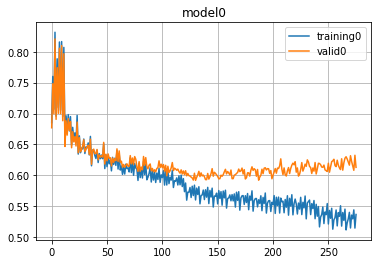

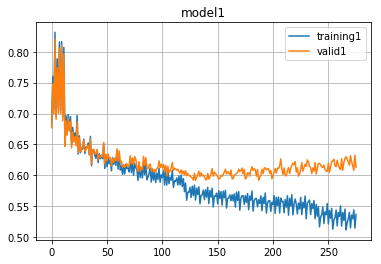

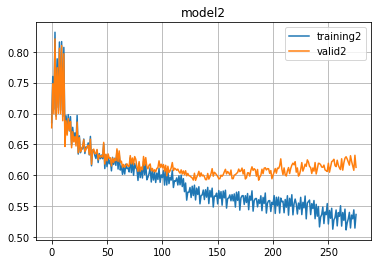

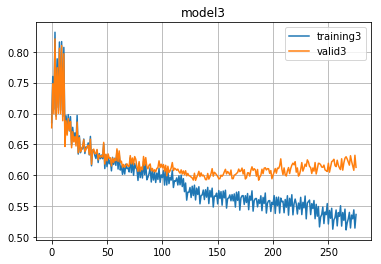

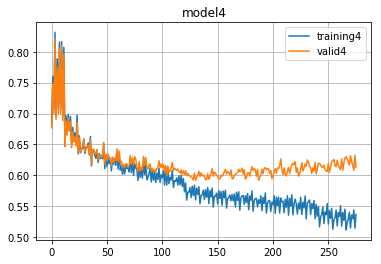

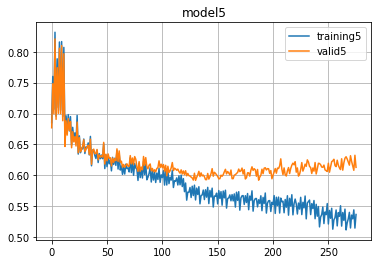

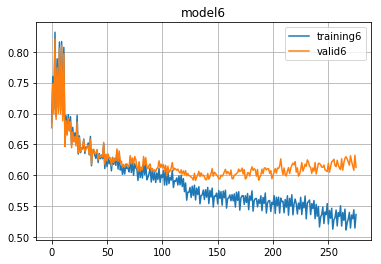

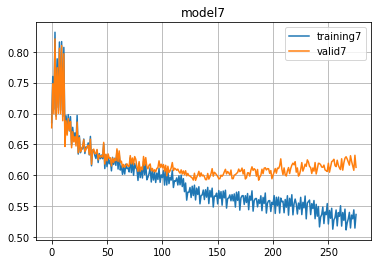

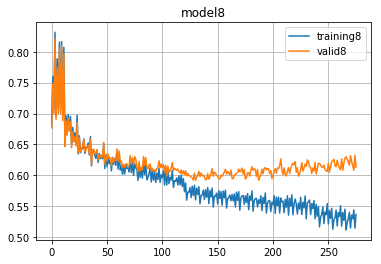

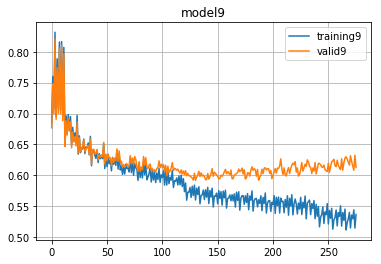

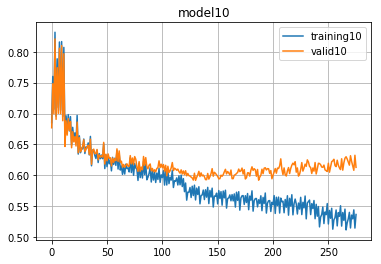

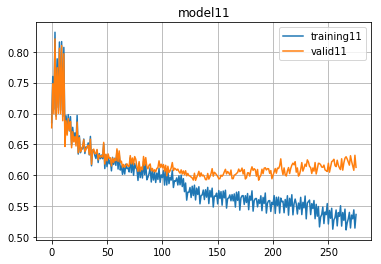

In [12]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

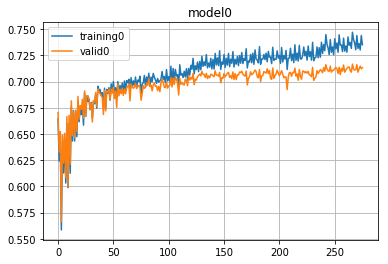

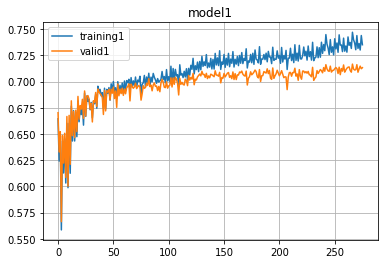

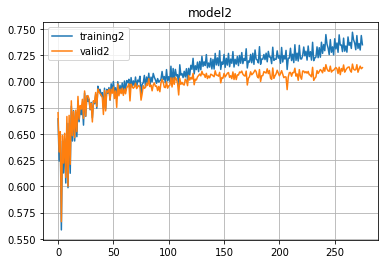

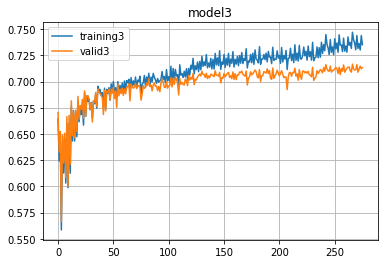

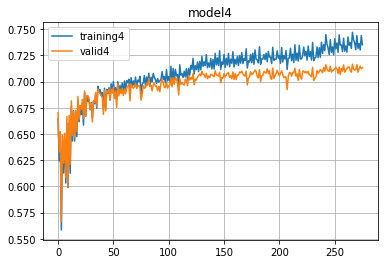

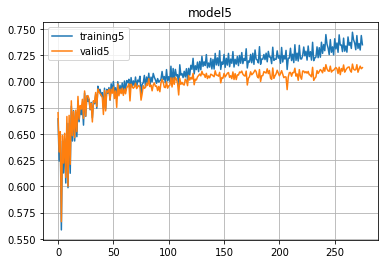

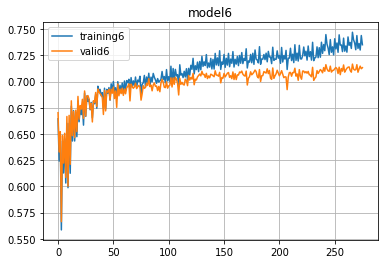

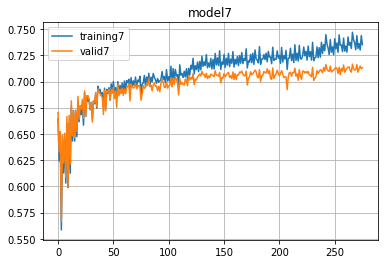

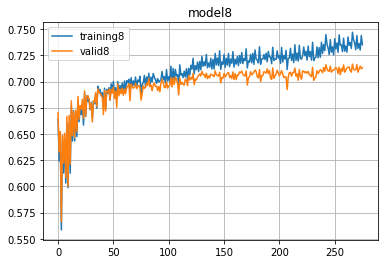

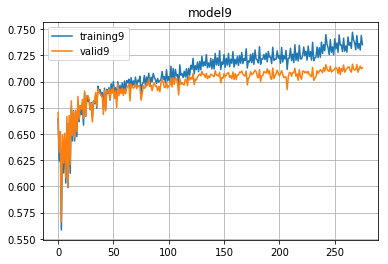

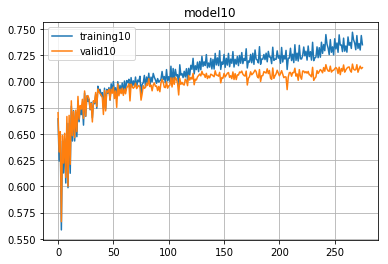

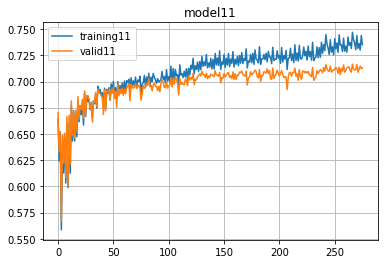

In [13]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

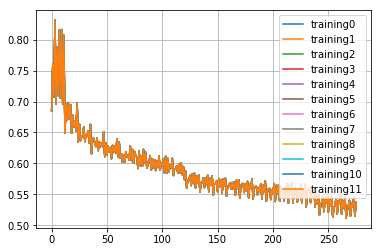

In [14]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

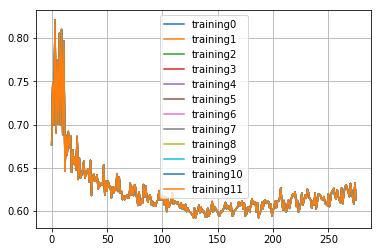

In [15]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

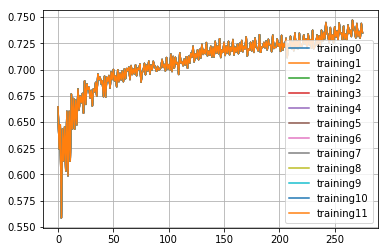

In [16]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

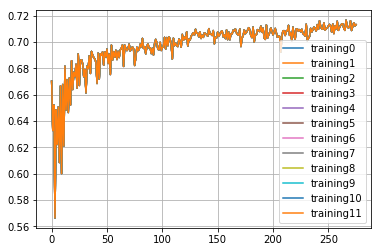

In [17]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

 <br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [18]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    num_values = len(activity1.values[0])
    
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

    total_lst = activity
    return total_lst, label

In [19]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [20]:
print(test_data.shape)

(40000, 8, 38)


<br></br><br></br><br></br> 

# Predict

In [21]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

week: 12580, month: 7542, 2month: 19878, retained: 0
week: 12260, month: 8008, 2month: 19732, retained: 0
week: 12396, month: 10052, 2month: 17552, retained: 0
week: 11972, month: 7141, 2month: 20887, retained: 0
week: 12451, month: 12661, 2month: 14888, retained: 0
week: 11778, month: 12340, 2month: 15882, retained: 0
week: 12346, month: 7609, 2month: 20045, retained: 0
week: 12385, month: 8484, 2month: 19131, retained: 0
week: 12363, month: 10655, 2month: 16982, retained: 0
week: 12211, month: 7761, 2month: 20028, retained: 0
week: 12498, month: 13336, 2month: 14166, retained: 0
week: 12129, month: 11714, 2month: 16157, retained: 0


In [1]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

NameError: name 'pd' is not defined

In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()